# Audio Waveform and Mel-Spectrogram Visualization
This notebook demonstrates how to visualize an audio waveform and its corresponding Mel-spectrogram using the NSynth dataset and torchaudio library.

Key: keyboard_electronic_002-022-050
Original audio:


mel_spec_db.shape =  torch.Size([1, 80, 251])


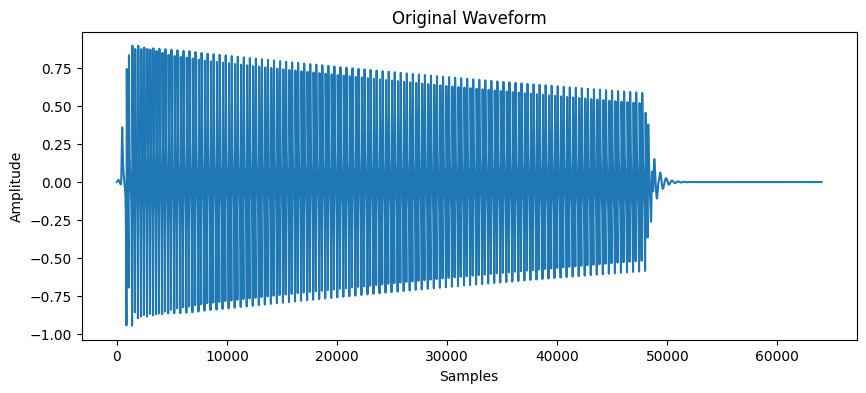

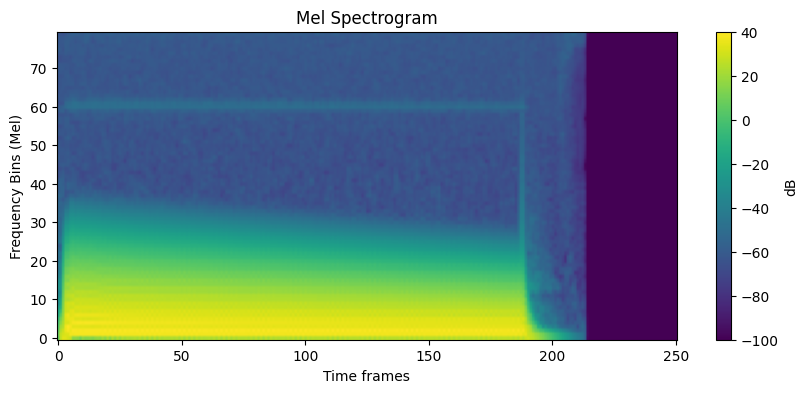

reconstructed.shape =  (80, 251)
Reconstructed audio:


In [ ]:
%run init_notebook.py

import torch
import torchaudio
import librosa
import numpy as np
import random
from IPython.display import display

from src.dataset import NSynth
from src.utils.audio_utils import *
from src.utils.audio_utils import listen

# 1) Load dataset and pick a sample
dataset = NSynth('testing')

# 3) Define MelSpectrogram transforms
sample_rate = 16000
n_fft = 4096
hop_length = 512 # n_fft // 2
n_mels = 512

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
)
db_transform = torchaudio.transforms.AmplitudeToDB(stype="power")
test_indeces = [random.choice(range(len(dataset))) for _ in range(5)]

for i in range(len(test_indeces)):

    waveform, sample_rate, key, _ = dataset[i]
    print(f"Original audio {key}:")
    display(listen(waveform, sample_rate))
    
    with torch.no_grad():
        mel_spec = mel_transform(waveform)   # [1, n_mels, time_frames]
        mel_spec_db = db_transform(mel_spec) # [1, n_mels, time_frames]

    plot_waveform(waveform)
    plot_mel_spectogram(mel_spec_db)

    n_iter = 512  # Iterations for Griffin-Lim Algorithm
    mel_db_np = mel_spec_db.squeeze(0).numpy()
    mel_power = librosa.db_to_power(mel_db_np)
    reconstructed_waveform = librosa.feature.inverse.mel_to_audio(
        mel_power, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_iter=n_iter
    )

    # 7) Listen to reconstruction
    print("Reconstructed audio:")
    display(listen(reconstructed_waveform, sample_rate))


In [ ]:
%run init_notebook.py

import torch
import torchaudio
import librosa
import numpy as np
import random
from IPython.display import display

from src.dataset import NSynth
from src.utils.audio_utils import *
from src.utils.audio_utils import listen

# 1) Load dataset and pick a sample
dataset = NSynth('testing')

# 3) Define STFT transforms
sample_rate = 16000
n_fft = 4096
hop_length = 512
win_length = n_fft  # Same as n_fft

stft_transform = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=None,  # Keep as magnitude spectrogram
)

# Define the inverse STFT function (use torchaudio for reconstruction)
istft_transform = torchaudio.transforms.InverseSpectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

# Select a few random indices for testing
test_indeces = [random.choice(range(len(dataset))) for _ in range(5)]

for i in range(len(test_indeces)):

    waveform, sample_rate, key, _ = dataset[i]
    print(f"Original audio {key}:")
    display(listen(waveform, sample_rate))
    
    with torch.no_grad():
        # Apply STFT transformation (this gives complex output)
        stft_spec = stft_transform(waveform)  # [1, freq_bins, time_frames]
        
        # Extract magnitude and phase
        magnitude = stft_spec.abs()  # Magnitude spectrogram
        phase = torch.angle(stft_spec)  # Phase information

    # Reconstruct audio using ISTFT (combine magnitude and phase)
    # Rebuild the complex spectrogram from magnitude and phase
    complex_spec = magnitude * torch.exp(1j * phase)

    # Now, pass the complex spectrogram to the ISTFT
    reconstructed_waveform = istft_transform(complex_spec)

    # 7) Listen to the reconstruction
    print("Reconstructed audio:")
    display(listen(reconstructed_waveform, sample_rate))
